In [1]:
import pandas as pd, os, os.path as op, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
sns.set()

####### SET DPI HERE #######
DPI = 600 ##################
############################

u = lambda x: list(set(x))

#make necessary folders
if not op.exists('plots'):
    os.mkdir('plots')
    


In [2]:
q = pd.read_excel(op.join('data',"quest.xlsx"))
c = pd.read_excel(op.join('data',"cogn.xlsx"))

q = q.rename({'Participant Private ID':'id','Grupa':'group','Czy uzywa klawiatury i myszy zewnętrznej do gry lub pracy?':'keymouseuse',
         'Wiek':'age','Płec':'sex','Stan cywilny':'marital','Najwyższy ukonczony stopień edukacji':'edu',
          'Liczba ukończonych lat edukacji':'eduyears','Wielkość miasta zamieszkania':'size','Częstotliwość gry lub pracy':'pwfreq',
         'Ile pełnych lat gra lub pracuje':'pwyears','Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach':'pwhrsdaily3mo',
         'Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach':'pwhrsweekly3mo',
          'Czy kiedykolwiek czerpał korzyści materialne z grania w gry komputerowe?':'gainsever',
          'Czy obecnie utrzymuje się z grania w gry komputerowe?':'upkeepgamesnow',
         'Czy planuje kiedyś utrzymywać się z grania w gry komputerowe?':'upkeepgamesfuture'}, axis = 1)

c = c.rename({'Participant Private ID':'id','Zadanie':'task','Warunek':'condition',"Timed Out":'timeout'},axis=1)
c.columns = [col.lower() for col in c.columns]

q["group"] = q["group"].map({'Regularnie gram w League of Legends':"LoL",
                'Regularnie gram w Counter Strike: Global Offensive':"CS:GO",
                'Regularnie pracuję przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Praca",
                'Regularnie pracuję lub uczę się przy komputerze i nie gram w gry lub robię to rzadko (gry na konsole i smartfony nie są wliczane)':"Praca"})

#drop columns with no variability
q = q.drop([col for col in q.columns if q[col].nunique() == 1],axis=1)


q['marital'] = q['marital'].map({'Kawaler/ panna':"Kawaler",'Żonaty/ zamężna':'Żonaty'})

#add group info to cognitive df
c["group"] = c['id'].map({pid:q[q['id'] == pid]['group'].values[0] for pid in q['id'].unique()})

#change nans into zeros, drop trials with more attempts than possible
c['attempt'] = c['attempt'].replace({np.nan:0})
c = c[c['attempt'] <= 5]

c['trialtype'] = c['task'].apply(lambda x: x.split(":")[-1])
c['task'] = c['task'].apply(lambda x: x.split(":")[0])
c['task'] = c['task'].map({'Go/No-Go':'gonogo','Cued Task Switching':'cts','Posner Cueing Task':'posner','Visual Search Click on Location':'vsc'})

In [3]:
cDict = {}

for task in u([t.split(":")[0] for t in c['task'].unique()]):
    cDict[task] = c[c.task.str.contains(task)]
    
    if task == 'gonogo':
        cDict[task]['trialtype'] = cDict[task]['trialtype'].apply(lambda x: x.split()[0])
    else:
        cDict[task] = cDict[task].drop(['trialtype'],axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


#### Go/No Go task analyses below

In [4]:
d = cDict['gonogo'].copy()
d = d[d['rt'] >= 100]

d.loc[d["attempt"] == 0,'rt'] = np.nan
d['correct_'] = d['correct'].map({1:'correct',0:'incorrect'})

d['condcorr'] = d.apply(lambda x: f"{x['condition']} - {x['correct_']}", axis = 1)

In [6]:
#RT for each condition and correct/incorrect separately

dDescRT = d.groupby(['id','group','condition','condcorr']).agg(
    n = pd.NamedAgg(column='rt', aggfunc=np.size),
    rt_mean = pd.NamedAgg(column='rt', aggfunc=np.mean)
).reset_index()

#RT regaradless of condition
dDescRT2 = d.groupby(['id','group']).agg(
    n = pd.NamedAgg(column='rt', aggfunc=np.size),
    rt_mean = pd.NamedAgg(column='rt', aggfunc=np.mean)
).reset_index()

In [46]:
_d = d.groupby(['id']).agg(
    n = pd.NamedAgg(column='rt', aggfunc=np.size),
    rt_mean = pd.NamedAgg(column='rt', aggfunc=np.mean)
).reset_index()

pg.normality(data=_d["rt_mean"]).round(3)

,W,pval,normal
rt_mean,0.807,0.0,False


In [25]:
dDescRT['groupXcondcorr'] = dDescRT['group'] + " " + dDescRT['condition']

In [39]:
pg.normality(data=dDescRT, dv="rt_mean",group='groupXcondcorr').round(3)

,W,pval,normal
LoL Go,0.940,0.242,True
LoL No Go,0.965,0.658,True
Praca Go,0.804,0.001,False
Praca No Go,0.806,0.001,False
CS:GO Go,0.872,0.013,False
CS:GO No Go,0.938,0.220,True


In [40]:
pg.normality(data=dDescRT2, dv="rt_mean",group='group').round(3)

,W,pval,normal
LoL,0.944,0.289,True
Praca,0.802,0.001,False
CS:GO,0.871,0.012,False


#### grupa a czas reakcji w zadaniu go/nogo (wszystkie triale)

In [45]:
pg.homoscedasticity(dDescRT2, group='group', dv='rt_mean')

,W,pval,equal_var
levene,2.334156,0.106088,True


In [28]:
aov = pg.anova(dv='rt_mean', between='group', data=dDescRT2,
               detailed=True).round(3)

In [29]:
aov

,Source,SS,DF,MS,F,p-unc,np2
0,group,37177.359,2,18588.679,10.503,0.0,0.269
1,Within,100879.199,57,1769.811,NaN,NaN,NaN


In [17]:
pg.pairwise_ttests(data=dDescRT2, dv='rt_mean', between='group', parametric=True, marginal=True,
            alpha=0.05, tail='two-sided', padjust='sidak', effsize='hedges', correction='auto',
                nan_policy='listwise', return_desc=True, interaction=True, within_first=True).round(3)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,group,LoL,Praca,360.272,25.474,414.477,60.969,False,True,-3.669,38.0,two-sided,0.001,0.002,sidak,39.759,-1.137
1,group,LoL,CS:GO,360.272,25.474,363.194,30.713,False,True,-0.327,38.0,two-sided,0.745,0.983,sidak,0.322,-0.101
2,group,Praca,CS:GO,414.477,60.969,363.194,30.713,False,True,3.359,38.0,two-sided,0.002,0.005,sidak,19.39,1.041


Występują istotne statystycznie różnice w czasach reakcji między grupami:

Pracujący mają dłuższe czasy reakcji zarówno od LoL, jak i od CS:GO

LoL i CS:GO nie różnią się od siebie.


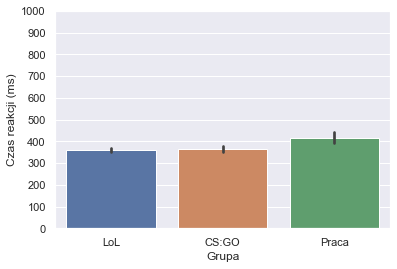

In [144]:
g = sns.barplot(data=dDescRT2,x='group',y='rt_mean',order=['LoL',"CS:GO","Praca"])
g.set(yticks=range(0,1001,100))
plt.xlabel("Grupa")
plt.ylabel("Czas reakcji (ms)")
plt.savefig(op.join('plots','gonogo_group_rt_mean.png'),dpi = DPI,bbox_inches = "tight")
plt.show()
plt.close()

#### grupa a czas reakcji w warunku go

In [22]:
dDescRT_GO = dDescRT[dDescRT['condcorr'] == "Go - correct"]

In [46]:
pg.homoscedasticity(dDescRT_GO, group='group', dv='rt_mean')

,W,pval,equal_var
levene,2.357783,0.103797,True


In [26]:
aov = pg.anova(dv='rt_mean', between='group', data=dDescRT_GO,
               detailed=True).round(3)

In [27]:
aov

,Source,SS,DF,MS,F,p-unc,np2
0,group,34904.649,2,17452.325,9.832,0.0,0.256
1,Within,101176.705,57,1775.030,NaN,NaN,NaN


In [31]:
pg.pairwise_ttests(data=dDescRT_GO, dv='rt_mean', between='group', parametric=True, marginal=True,
            alpha=0.05, tail='two-sided', padjust='sidak', effsize='hedges', correction='auto',
                nan_policy='listwise', return_desc=True, interaction=True, within_first=True).round(3)

,Contrast,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,group,LoL,Praca,362.659,25.684,415.038,61.227,False,True,-3.528,38.0,two-sided,0.001,0.003,sidak,28.543,-1.093
1,group,LoL,CS:GO,362.659,25.684,365.180,30.278,False,True,-0.284,38.0,two-sided,0.778,0.989,sidak,0.319,-0.088
2,group,Praca,CS:GO,415.038,61.227,365.180,30.278,False,True,3.264,38.0,two-sided,0.002,0.007,sidak,15.674,1.012


Występują istotne statystycznie różnice w czasach reakcji w warunku GO między grupami:

Pracujący mają dłuższe czasy reakcji zarówno od LoL, jak i od CS:GO

LoL i CS:GO nie różnią się od siebie.

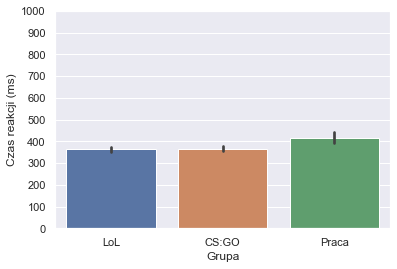

In [145]:
g = sns.barplot(data=dDescRT_GO,x='group',y='rt_mean',order=['LoL',"CS:GO","Praca"])
g.set(yticks=range(0,1001,100))
plt.xlabel("Grupa")
plt.ylabel("Czas reakcji (ms)")
plt.savefig(op.join('plots','gonogo_group_rt_mean_GO TASK.png'),dpi = DPI,bbox_inches = "tight")
plt.show()
plt.close()

#### grupa a czas reakcji w warunku no go

In [34]:
dDescRT_NOGO = dDescRT[dDescRT['condcorr'] == "No Go - incorrect"]

In [47]:
pg.homoscedasticity(dDescRT_NOGO, group='group', dv='rt_mean')

,W,pval,equal_var
levene,3.87892,0.026444,False


In [49]:
aov = pg.welch_anova(dv='rt_mean', between='group', data=dDescRT_NOGO).round(3)

In [50]:
aov

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,33.499,6.965,0.003,0.267


In [63]:
pg.pairwise_gameshowell(data=dDescRT_NOGO, dv='rt_mean', between='group', effsize='hedges').round(3)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,CS:GO,LoL,342.499,329.162,13.337,9.234,1.444,36.122,0.320,0.448
1,CS:GO,Praca,342.499,395.610,-53.111,18.498,-2.871,24.338,0.013,-0.901
2,LoL,Praca,329.162,395.610,-66.448,17.964,-3.699,22.051,0.001,-1.161


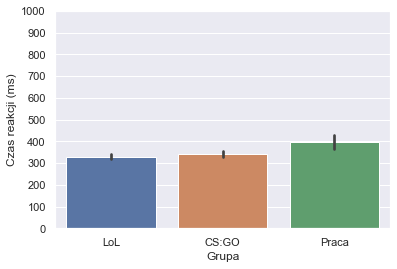

In [146]:
g = sns.barplot(data=dDescRT_NOGO,x='group',y='rt_mean',order=['LoL',"CS:GO","Praca"])
g.set(yticks=range(0,1001,100))
plt.xlabel("Grupa")
plt.ylabel("Czas reakcji (ms)")
plt.savefig(op.join('plots','gonogo_group_rt_mean_NOGO TASK.png'),dpi = DPI,bbox_inches = "tight")
plt.show()
plt.close()

Występują istotne statystycznie różnice w czasach reakcji w warunku NO GO między grupami:

Pracujący mają dłuższe czasy reakcji zarówno od LoL, jak i od CS:GO

LoL i CS:GO nie różnią się od siebie.

#### ANOVA w schemacie mieszanym - grupa * warunek (go/nogo) a poprawność odpowiedzi

In [33]:
dDescPerc = d.groupby(['id','group','condition','condcorr']).agg(n = pd.NamedAgg(column='rt', aggfunc=np.size)).reset_index()

dDescPerc['correct'] = dDescPerc['n']/dDescPerc.groupby(['id','condition'])["n"].transform(np.sum)
dDescPerc = dDescPerc[dDescPerc['condcorr'].str.contains('- correct')]
dDescPerc = dDescPerc.drop(['condcorr'],axis=1)

In [49]:
pg.normality(data=dDescPerc['correct']).round(3)

,W,pval,normal
correct,0.726,0.0,False


In [34]:
dDescPerc['groupXcond'] = dDescPerc['group'] + " " + dDescPerc['condition']

In [38]:
pg.normality(data=dDescPerc, dv="correct",group='groupXcond').round(3)

,W,pval,normal
LoL Go,0.544,0.000,False
LoL No Go,0.873,0.013,False
Praca Go,0.743,0.000,False
Praca No Go,0.967,0.697,True
CS:GO Go,0.662,0.000,False
CS:GO No Go,0.780,0.000,False


In [42]:
aov = pg.mixed_anova(dv='correct', between='group',within='condition', subject='id', data=dDescPerc).round(3)

In [43]:
aov

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,0.321,2,57,0.161,11.228,0.0,0.283,NaN
1,condition,1.707,1,57,1.707,133.807,0.0,0.701,1.0
2,Interaction,0.342,2,57,0.171,13.393,0.0,0.320,NaN


Jest efekt główny warunku: poprawniej rozwiązywano go niż no-go (rząd 0 poniżej)

Jest efekt główny grupy: poprawniej rozwiązywali niegrający niż grający. CSGO i LoL nie różnią się od siebie (rzędy 1-3)

Jest efekt interakcji:

W warunku GO:
- nie występują istotne statystyczne różnice w poprawności między grupami (rzędy 4-6)

W warunku NO GO:
- Grupy grajace nie różnią się poprawnością wykonania zadania (rząd 8)
- Niegrający wykonują zadanie poprawniej od grających (rzędy 7 i 9)



In [44]:
pg.pairwise_ttests(data=dDescPerc, dv='correct', between='group',within='condition', subject='id', parametric=True, marginal=True,
            alpha=0.05, tail='two-sided', padjust='sidak', effsize='hedges', correction='auto',
                nan_policy='listwise', return_desc=True, interaction=True, within_first=True).round(3)

,Contrast,condition,A,B,mean(A),std(A),mean(B),std(B),Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,condition,-,Go,No Go,0.993,0.012,0.754,0.193,True,True,9.707,59.0,two-sided,0.000,NaN,NaN,9.78e+10,1.734
1,group,-,LoL,Praca,0.832,0.099,0.946,0.029,False,True,-4.948,38.0,two-sided,0.000,0.000,sidak,1086.39,-1.534
2,group,-,LoL,CS:GO,0.832,0.099,0.842,0.104,False,True,-0.303,38.0,two-sided,0.764,0.987,sidak,0.32,-0.094
3,group,-,Praca,CS:GO,0.946,0.029,0.842,0.104,False,True,4.340,38.0,two-sided,0.000,0.000,sidak,213.062,1.345
4,condition * group,Go,LoL,Praca,0.996,0.009,0.991,0.013,False,True,1.388,38.0,two-sided,0.173,0.681,sidak,0.659,0.430
5,condition * group,Go,LoL,CS:GO,0.996,0.009,0.992,0.013,False,True,1.046,38.0,two-sided,0.302,0.884,sidak,0.476,0.324
6,condition * group,Go,Praca,CS:GO,0.991,0.013,0.992,0.013,False,True,-0.322,38.0,two-sided,0.749,1.000,sidak,0.322,-0.100
7,condition * group,No Go,LoL,Praca,0.669,0.192,0.902,0.061,False,True,-5.175,38.0,two-sided,0.000,0.000,sidak,2032.406,-1.604
8,condition * group,No Go,LoL,CS:GO,0.669,0.192,0.692,0.200,False,True,-0.373,38.0,two-sided,0.711,0.999,sidak,0.326,-0.116
9,condition * group,No Go,Praca,CS:GO,0.902,0.061,0.692,0.200,False,True,4.503,38.0,two-sided,0.000,0.000,sidak,327.055,1.396


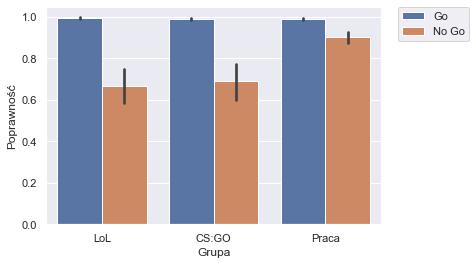

In [149]:
g = sns.barplot(data=dDescPerc,x='group',y='correct',hue='condition',order=['LoL',"CS:GO","Praca"])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set(xlabel='Grupa',ylabel='Poprawność')
plt.savefig(op.join('plots','gonogo_group_task_correctness.png'),dpi = DPI,bbox_inches = "tight")
plt.show()
plt.close()

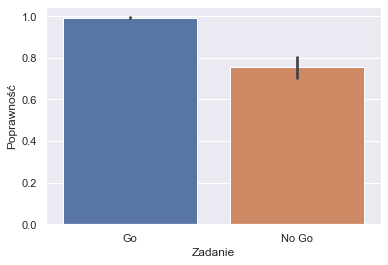

In [152]:
g = sns.barplot(data=dDescPerc,x='condition',y='correct',order=['Go',"No Go"])
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set(xlabel='Zadanie',ylabel='Poprawność')
plt.savefig(op.join('plots','gonogo_task_correctness.png'),dpi = DPI,bbox_inches = "tight")
plt.show()
plt.close()

In [53]:
pg.normality(data=dDescPerc, dv="correct",group='group').round(3)

,W,pval,normal
LoL,0.794,0.0,False
Praca,0.829,0.0,False
CS:GO,0.754,0.0,False


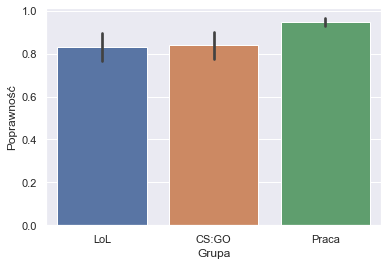

In [150]:
g = sns.barplot(data=dDescPerc,x='group',y='correct',order=['LoL',"CS:GO","Praca"])
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set(xlabel='Grupa',ylabel='Poprawność')
plt.savefig(op.join('plots','gonogo_group_correctness.png'),dpi = DPI,bbox_inches = "tight")
plt.show()
plt.close()

#### Poprawność oddzielnie dla warunków P i R

In [78]:
dpr = d.groupby(['id','group','correct_','trialtype']).agg(n = pd.NamedAgg(column='rt', aggfunc=np.size)).reset_index()

dpr['correct'] = dpr['n']/dpr.groupby(['id','trialtype'])["n"].transform(np.sum)
dpr = dpr[dpr['correct_'] == 'correct']
dpr = dpr.drop(['correct_'],axis=1)

In [79]:
aov = pg.mixed_anova(dv='correct', between='group',within='trialtype', subject='id', data=dpr)

In [80]:
aov

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,group,0.046742,2,57,0.023371,8.284431,0.000694,0.225216,NaN
1,trialtype,0.001375,1,57,0.001375,4.008159,0.050047,0.065699,1.0
2,Interaction,0.000694,2,57,0.000347,1.011688,0.370039,0.034281,NaN


##### Efekt grupy pominę - już powyżej opisany; reszta nieistotna

In [83]:
q.head()

,id,group,keymouseuse,marital,edu,eduyears,size,pwfreq,pwyears,pwhrsdaily3mo,pwhrsweekly3mo,gainsever,upkeepgamesnow,upkeepgamesfuture
0,2259446,LoL,Tak,Kawaler,Średni zawodowy,13,100-500 000,Codziennie,10,3,26,Tak,Nie,Nie
1,2260116,LoL,Tak,Kawaler,Średni zawodowy,13,<10 000,5-6 dni w tygodniu,5,4,20,Nie,Nie,Nie
2,2260229,LoL,Tak,Kawaler,Średni ogólnokształcący,12,>500 000,3-4 dni w tygodniu,8,3,12,Nie,Nie,Nie
3,2260318,LoL,Tak,Kawaler,Średni zawodowy,13,<10 000,3-4 dni w tygodniu,6,4,20,Tak,Nie,Nie
4,2260455,LoL,Tak,Kawaler,Policealny,17,100-500 000,Codziennie,10,3,21,Tak,Nie,Tak


In [42]:
q2 = q[['id','group','pwyears','pwhrsdaily3mo','pwhrsweekly3mo']]

In [50]:
pg.normality(data=q2["pwyears"]).round(3)

,W,pval,normal
pwyears,0.938,0.005,False


In [43]:
pg.normality(data=q2, dv="pwyears",group='group').round(3)

,W,pval,normal
LoL,0.932,0.169,True
Praca,0.907,0.055,True
CS:GO,0.944,0.280,True


In [51]:
pg.normality(data=q2["pwhrsdaily3mo"]).round(3)

,W,pval,normal
pwhrsdaily3mo,0.715,0.0,False


In [44]:
pg.normality(data=q2, dv="pwhrsdaily3mo",group='group').round(3)

,W,pval,normal
LoL,0.903,0.047,False
Praca,0.934,0.184,True
CS:GO,0.683,0.000,False


In [52]:
pg.normality(data=q2["pwhrsweekly3mo"]).round(3)

,W,pval,normal
pwhrsweekly3mo,0.811,0.0,False


In [45]:
pg.normality(data=q2, dv='pwhrsweekly3mo',group='group').round(3)

,W,pval,normal
LoL,0.900,0.042,False
Praca,0.902,0.045,False
CS:GO,0.725,0.000,False


#### Moderacja => zmienne kwestionariuszowe * grupa (gracze/niegracze) a czas reakcji

In [102]:
mod1 = pd.merge(dDescRT2, q2)
mod1['group'] = mod1['group'].map({"LoL":1,"CS:GO":1,"Praca":0})

for v in ["pwyears","pwhrsdaily3mo","pwhrsweekly3mo"]:
    mod1[f'group_{v}'] = mod1['group']*mod1[v]


### Ile pełnych lat gra lub pracuje

In [111]:
pg.linear_regression(X = mod1[['pwyears','group','group_pwyears']], y= mod1['rt_mean'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,427.747,19.212,22.264,0.000,0.288,0.25,389.260,466.233
1,pwyears,-3.539,4.473,-0.791,0.432,0.288,0.25,-12.499,5.421
2,group,-53.730,24.146,-2.225,0.030,0.288,0.25,-102.100,-5.361
3,group_pwyears,1.232,5.099,0.242,0.810,0.288,0.25,-8.983,11.447


Nie ma efektu lat - nie przekłada się do na zmianę czasu reakcji, jest efekt grupy (ale to już wiemy z poprzednich analiz)
Nie ma efektu interakcji, czyli nie ma moderacji

### Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach

In [112]:
pg.linear_regression(X = mod1[['pwhrsdaily3mo','group','group_pwhrsdaily3mo']], y= mod1['rt_mean'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,467.511,31.734,14.732,0.000,0.307,0.27,403.939,531.083
1,pwhrsdaily3mo,-8.554,4.897,-1.747,0.086,0.307,0.27,-18.363,1.255
2,group,-102.869,33.854,-3.039,0.004,0.307,0.27,-170.687,-35.052
3,group_pwhrsdaily3mo,8.041,5.193,1.548,0.127,0.307,0.27,-2.362,18.445


Nie ma efektu godzin dziennie w ostatnich 3 mies - nie przekłada się do na zmianę czasu reakcji, jest efekt grupy (ale to już wiemy z poprzednich analiz)
Nie ma efektu interakcji, czyli nie ma moderacji

### Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach

In [129]:
pg.linear_regression(X = mod1[['pwhrsweekly3mo','group','group_pwhrsweekly3mo']], y= mod1['rt_mean'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,436.646,30.841,14.158,0.000,0.279,0.24,374.863,498.429
1,pwhrsweekly3mo,-0.684,0.906,-0.755,0.453,0.279,0.24,-2.500,1.131
2,group,-70.151,33.226,-2.111,0.039,0.279,0.24,-136.710,-3.592
3,group_pwhrsweekly3mo,0.546,0.955,0.572,0.570,0.279,0.24,-1.368,2.460


Nie ma efektu godzin tygodniowo w ostatnich 3 mies - nie przekłada się to na zmianę czasu reakcji, jest efekt grupy (ale to już wiemy z poprzednich analiz)
Nie ma efektu interakcji, czyli nie ma moderacji

In [123]:
mod2 = d.groupby(['id','group']).agg(
    correct = pd.NamedAgg(column='correct', aggfunc=np.mean)).reset_index()

mod2 = pd.merge(mod2, q2)
mod2['group'] = mod2['group'].map({"LoL":1,"CS:GO":1,"Praca":0})

for v in ["pwyears","pwhrsdaily3mo","pwhrsweekly3mo"]:
    mod2[f'group_{v}'] = mod2['group']*mod2[v]

#### Moderacja => zmienne kwestionariuszowe * grupa (gracze/niegracze) a poprawność odpowiedzi

### Ile pełnych lat gra lub pracuje

In [126]:
pg.linear_regression(X = mod2[['pwyears','group','group_pwyears']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.969,0.017,56.418,0.000,0.243,0.203,0.934,1.003
1,pwyears,0.001,0.004,0.293,0.770,0.243,0.203,-0.007,0.009
2,group,-0.024,0.022,-1.124,0.266,0.243,0.203,-0.067,0.019
3,group_pwyears,-0.004,0.005,-0.800,0.427,0.243,0.203,-0.013,0.005


Nie ma żadnego efektu, ani lata, ani bycie graczem/niegraczem, ani też interakcja nie prekładają się na poprawność

### Średnia liczba godzin gry lub pracy dziennie w ostatnich 3 miesiącach

In [130]:
pg.linear_regression(X = mod2[['pwhrsdaily3mo','group','group_pwhrsdaily3mo']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.956,0.026,36.338,0.000,0.366,0.332,0.904,1.009
1,pwhrsdaily3mo,0.003,0.004,0.656,0.515,0.366,0.332,-0.005,0.011
2,group,0.003,0.028,0.104,0.917,0.366,0.332,-0.053,0.059
3,group_pwhrsdaily3mo,-0.008,0.004,-1.774,0.082,0.366,0.332,-0.016,0.001


Nie ma żadnego efektu, ani czas gry/pracy dziennie w ostatnich 3 mies, ani bycie graczem/niegraczem, ani też interakcja nie prekładają się na poprawność

### Średnia liczba godzin gry lub pracy tygodniowo w ostatnich 3 miesiącach

In [131]:
pg.linear_regression(X = mod2[['pwhrsweekly3mo','group','group_pwhrsweekly3mo']], y= mod2['correct'],add_intercept=True).round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.959,0.026,36.363,0.000,0.298,0.261,0.906,1.012
1,pwhrsweekly3mo,0.000,0.001,0.562,0.576,0.298,0.261,-0.001,0.002
2,group,-0.007,0.028,-0.238,0.813,0.298,0.261,-0.064,0.050
3,group_pwhrsweekly3mo,-0.001,0.001,-1.278,0.206,0.298,0.261,-0.003,0.001


Nie ma żadnego efektu, ani czas gry/pracy tygodniowo w ostatnich 3 mies, ani bycie graczem/niegraczem, ani też interakcja nie prekładają się na poprawność